In [215]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import rioxarray
import xarray as xr
import rasterio as rio
import glob
import datetime
import geopandas as gpd
from datetime import timedelta
from scipy.optimize import curve_fit
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [55]:
# functions to load interferogram tifs to xarray
def xr_read_geotif(geotif_file_path, masked=True):
    """
    Reads in single or multi-band GeoTIFF as dask array.
    Inputs
    ----------
    GeoTIFF_file_path : GeoTIFF file path
    Returns
    -------
    ds : xarray.Dataset
        Includes rioxarray extension to xarray.Dataset
    """

    da = rioxarray.open_rasterio(geotif_file_path, masked=True)

    # Extract bands and assign as variables in xr.Dataset()
    ds = xr.Dataset()
    for i, v in enumerate(da.band):
        da_tmp = da.sel(band=v)
        da_tmp.name = "band" + str(i + 1)

        ds[da_tmp.name] = da_tmp

    # Delete empty band coordinates.
    # Need to preserve spatial_ref coordinate, even though it appears empty.
    # See spatial_ref attributes under ds.coords.variables used by rioxarray extension.
    del ds.coords["band"]

    # Preserve top-level attributes and extract single value from value iterables e.g. (1,) --> 1
    ds.attrs = da.attrs
    for key, value in ds.attrs.items():
        try:
            if len(value) == 1:
                ds.attrs[key] = value[0]
        except TypeError:
            pass

    return ds

def hyp3_to_xarray(hyp3_dir, file_type='snr_ncorr_clipped', epsg=32645, interpolate_na=False):
    
    dirs = os.listdir(hyp3_dir) #list generated interferograms
    datasets = []
    
    for idir in dirs:
        tif_path = glob.glob(f'{hyp3_dir}/{idir}/*/*{file_type}.tif')[0]
        tif_fn = os.path.split(tif_path)[-1]
        dates = f'{tif_fn[14:22]}_{tif_fn[23:31]}' #parse filename for interferogram dates
        start_date = datetime.datetime.strptime(dates[:8], '%Y%m%d')
        end_date = datetime.datetime.strptime(dates[-8:], '%Y%m%d')
        t_baseline = end_date - start_date
        
        src = xr_read_geotif(tif_path, masked=False) #read product to xarray ds
        src = src.assign_coords({"dates": dates})
        src = src.expand_dims("dates")
        
        src = src.assign_coords(start_date = ('dates', [start_date]))
        src = src.assign_coords(end_date = ('dates', [end_date]))
        src = src.assign_coords(t_baseline = ('dates', [t_baseline]))
        
        src = src.rename({'band1':file_type})
        src = src.rio.write_crs(epsg)
        # in future, should get spatial baseline, flight dir, and orbit from metadata
        
        if interpolate_na == True:
            src = src.interpolate_na(dim='x', method='linear').fillna(value=0)
        
        datasets.append(src)
       
    ds = xr.concat(datasets, dim="dates", combine_attrs="no_conflicts") #create dataset
    return ds 

In [3]:
# open ints and dems
hyp3_dir = './data'
offset_ds = hyp3_to_xarray(hyp3_dir)

In [39]:
offset_8yr_ds = offset_ds.where(offset_ds.t_baseline.dt.days >= 2900, drop=True)

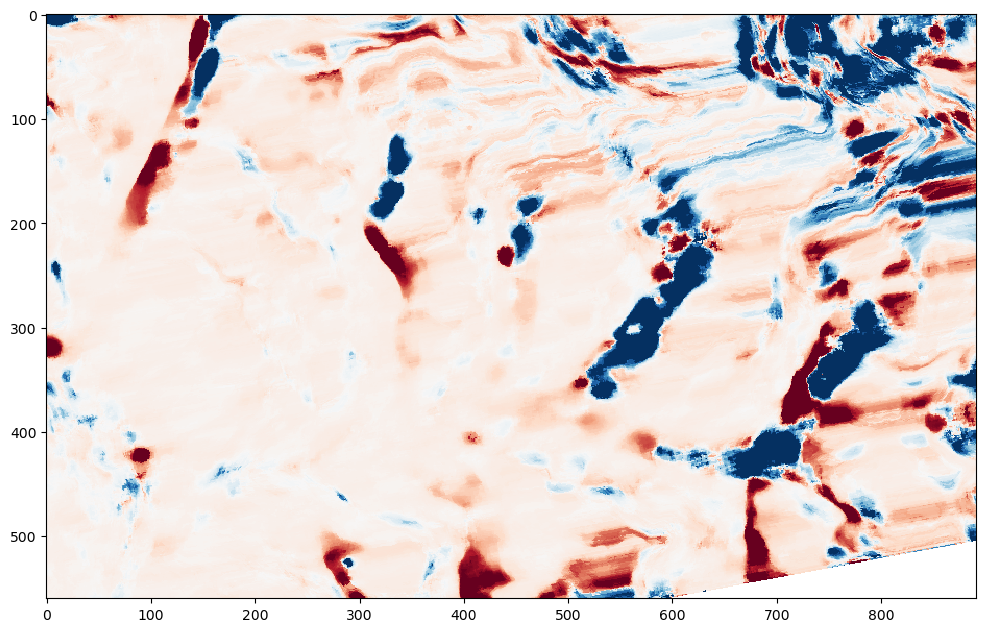

In [52]:
f, ax = plt.subplots(figsize=(12, 8))
ax.imshow(offset_8yr_ds.rng_off_notcorr_clipped.median(dim='dates')*2.3, interpolation='none', vmin=-6, vmax=6, cmap='RdBu_r')

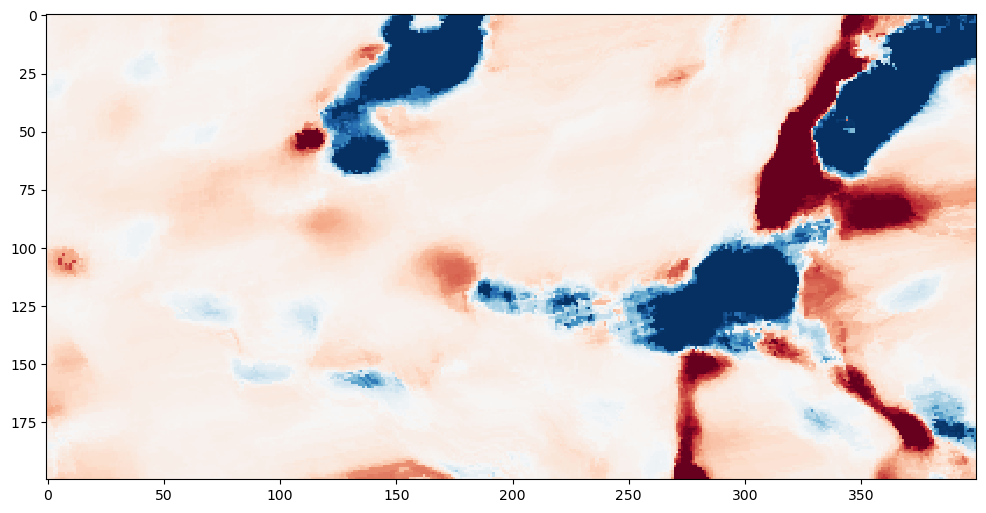

In [51]:
f, ax = plt.subplots(figsize=(12, 8))
ax.imshow(offset_8yr_ds.rng_off_notcorr_clipped.median(dim='dates')[300:500, 400:800], interpolation='none', vmin=-3, vmax=3, cmap='RdBu_r')
ax.set_aspect('equal')

In [42]:
offset_3yr_ds = offset_ds.where(offset_ds.t_baseline.dt.days <= 1200, drop=True)

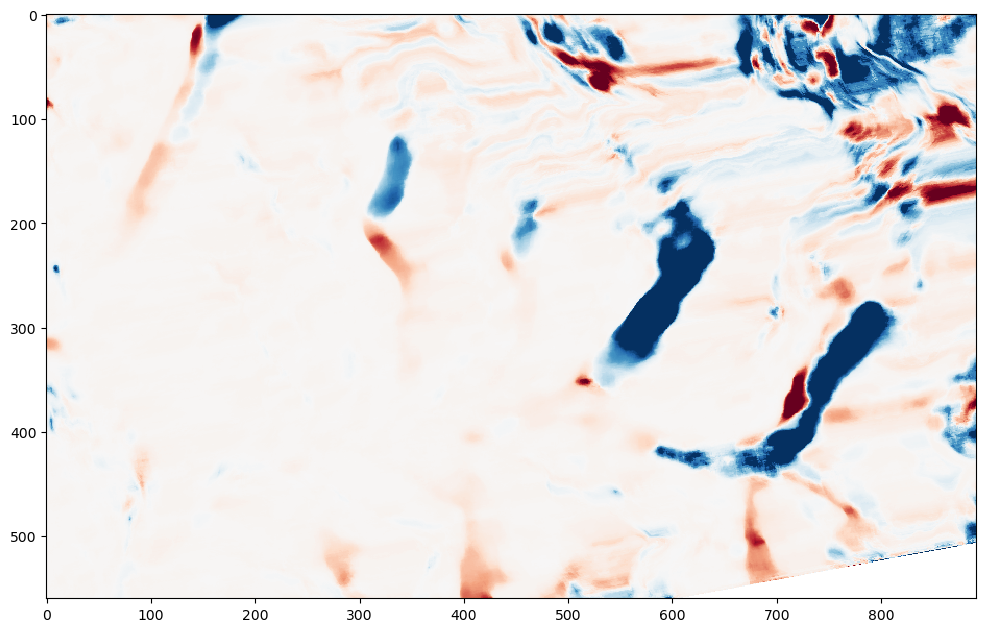

In [43]:
f, ax = plt.subplots(figsize=(12, 8))
ax.imshow(offset_3yr_ds.rng_off_notcorr_clipped.median(dim='dates'), interpolation='none', vmin=-3, vmax=3, cmap='RdBu_r')

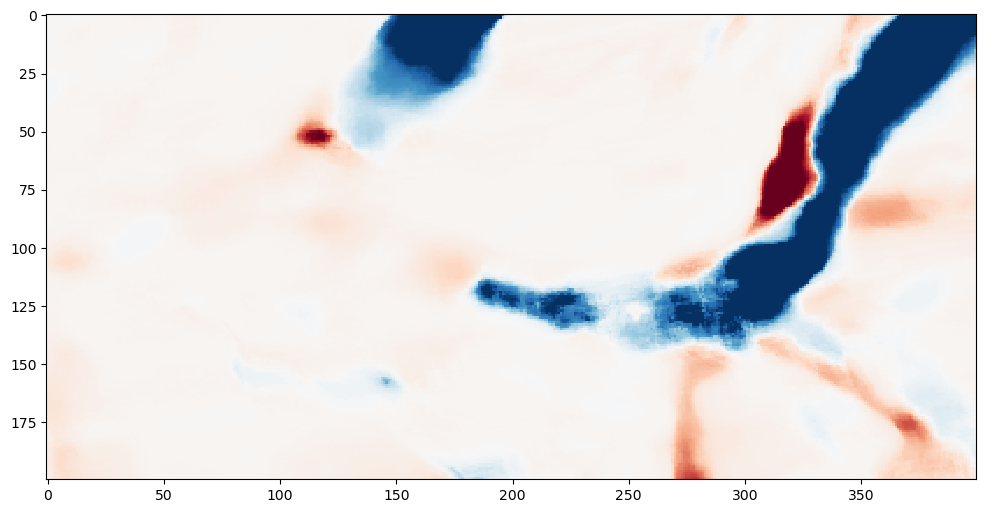

In [44]:
f, ax = plt.subplots(figsize=(12, 8))
ax.imshow(offset_3yr_ds.rng_off_notcorr_clipped.median(dim='dates')[300:500, 400:800], interpolation='none', vmin=-3, vmax=3, cmap='RdBu_r')

In [45]:
offset_6yr_ds = offset_ds.where(offset_ds.t_baseline.dt.days <= 2900, drop=True)
offset_6yr_ds = offset_6yr_ds.where(offset_ds.t_baseline.dt.days >= 1200, drop=True)

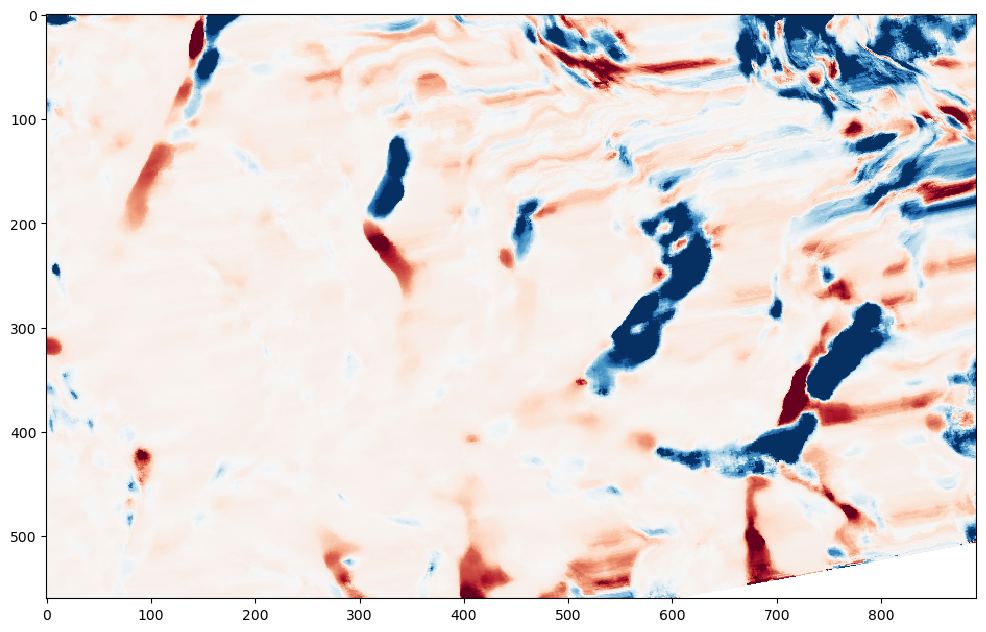

In [46]:
f, ax = plt.subplots(figsize=(12, 8))
ax.imshow(offset_6yr_ds.rng_off_notcorr_clipped.median(dim='dates'), interpolation='none', vmin=-3, vmax=3, cmap='RdBu_r')

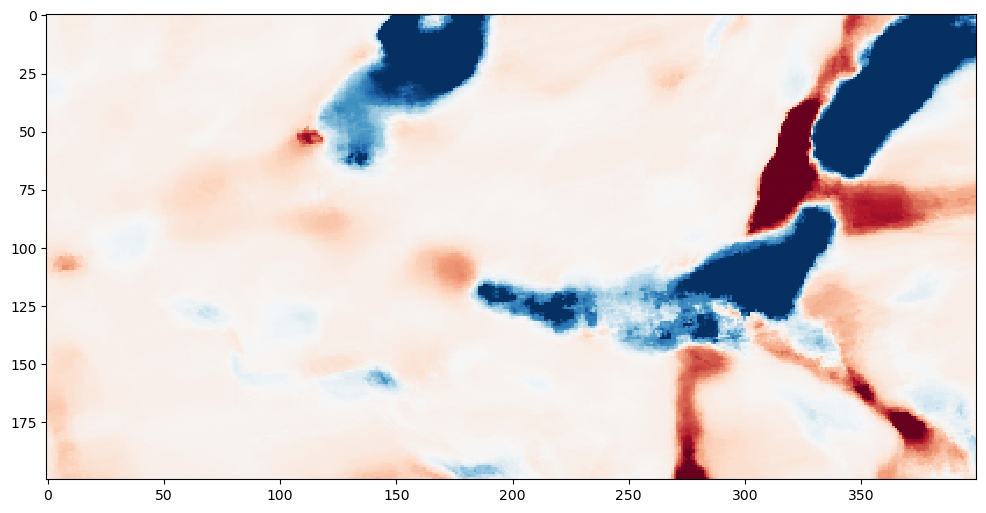

In [47]:
f, ax = plt.subplots(figsize=(12, 8))
ax.imshow(offset_6yr_ds.rng_off_notcorr_clipped.median(dim='dates')[300:500, 400:800], interpolation='none', vmin=-3, vmax=3, cmap='RdBu_r')

## SNR stacks

In [56]:
# open ints and dems
hyp3_dir = './data/data_offsets'
offset_ds = hyp3_to_xarray(hyp3_dir)

In [58]:
offset_8yr_ds = offset_ds.where(offset_ds.t_baseline.dt.days >= 2900, drop=True)
offset_6yr_ds = offset_ds.where(offset_ds.t_baseline.dt.days <= 2900, drop=True)
offset_6yr_ds = offset_6yr_ds.where(offset_ds.t_baseline.dt.days >= 1200, drop=True)
offset_3yr_ds = offset_ds.where(offset_ds.t_baseline.dt.days <= 1200, drop=True)

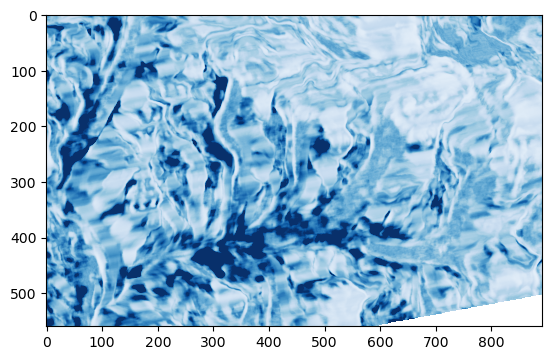

In [65]:
f, ax = plt.subplots()
ax.imshow(offset_8yr_ds.snr_ncorr_clipped.mean(dim='dates'), vmin=0, vmax=20, cmap='Blues')

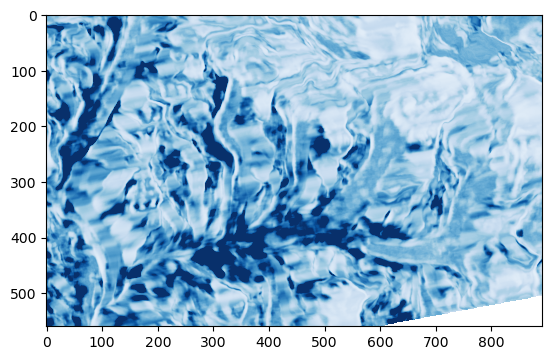

In [66]:
f, ax = plt.subplots()
ax.imshow(offset_6yr_ds.snr_ncorr_clipped.mean(dim='dates'), vmin=0, vmax=20, cmap='Blues')

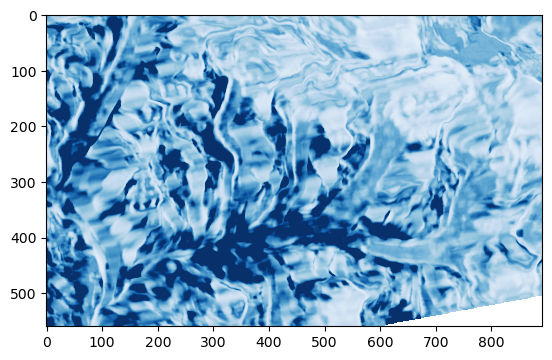

In [67]:
f, ax = plt.subplots()
ax.imshow(offset_3yr_ds.snr_ncorr_clipped.mean(dim='dates'), vmin=0, vmax=20, cmap='Blues')

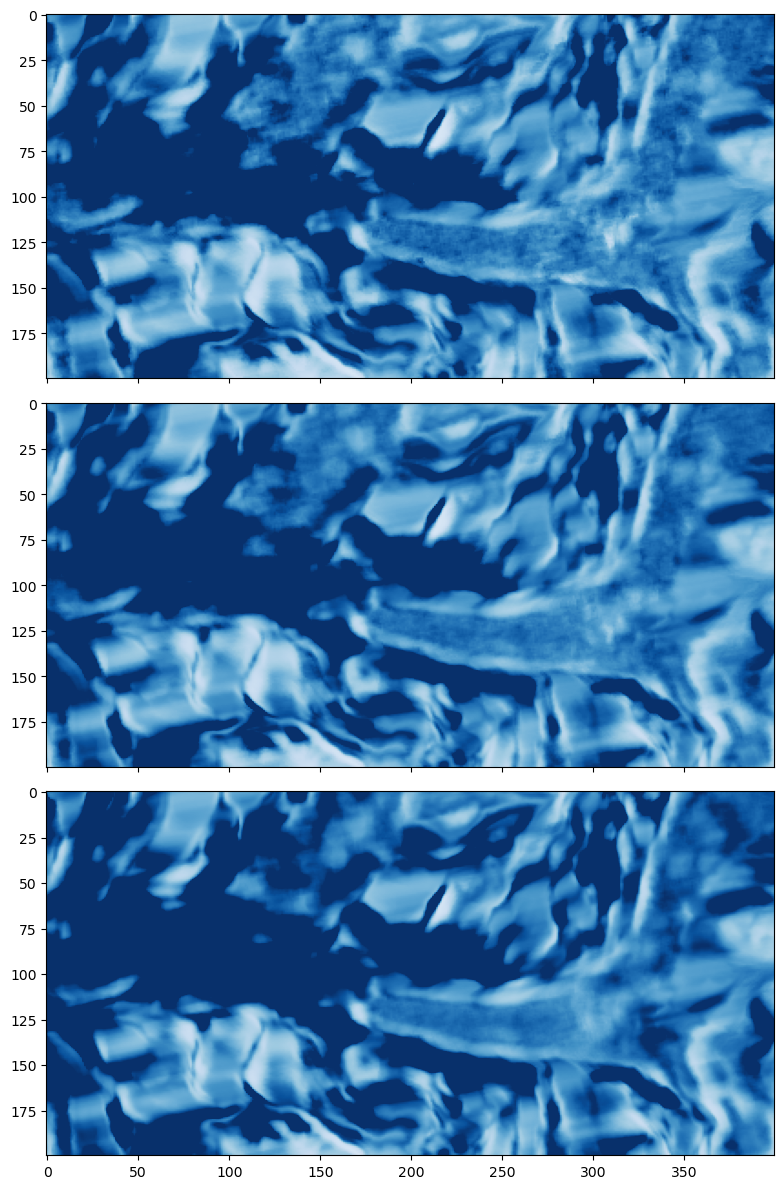

In [246]:
f, ax = plt.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=True)
ax[0].imshow(offset_8yr_ds.snr_ncorr_clipped.mean(dim='dates')[300:500, 400:800], vmin=0, vmax=13, cmap='Blues')
ax[1].imshow(offset_6yr_ds.snr_ncorr_clipped.mean(dim='dates')[300:500, 400:800], vmin=0, vmax=13, cmap='Blues')
ax[2].imshow(offset_3yr_ds.snr_ncorr_clipped.mean(dim='dates')[300:500, 400:800], vmin=0, vmax=13, cmap='Blues')
f.tight_layout()

In [77]:
def year_fraction(date):
    start = datetime.date(date.year.item(), 1, 1).toordinal()
    year_length = datetime.date(date.year.item()+1, 1, 1).toordinal() - start
    return date.year.item() + float(date.date.item().toordinal() - start) / year_length

In [79]:
# load json of aois
imja_fn = '/mnt/c/Users/qbren/Desktop/taco/projects/fusits/mapping/imja_moraine.shp'
imja_gdf = gpd.read_file(imja_fn)
imja_offset_ds = offset_ds.rio.clip(imja_gdf.geometry.values, crs=imja_gdf.crs, drop=True)
imja_offset_ds = imja_offset_ds.assign_coords(middle_date = ('dates', (imja_offset_ds.t_baseline/2+imja_offset_ds.start_date).data))

In [80]:
imja_offset_8yr_ds = imja_offset_ds.where(offset_ds.t_baseline.dt.days >= 2900, drop=True)
imja_offset_6yr_ds = imja_offset_ds.where(offset_ds.t_baseline.dt.days <= 2900, drop=True)
imja_offset_6yr_ds = imja_offset_6yr_ds.where(offset_ds.t_baseline.dt.days >= 1200, drop=True)
imja_offset_3yr_ds = imja_offset_ds.where(offset_ds.t_baseline.dt.days <= 1200, drop=True)

In [81]:
ds_list = [imja_offset_8yr_ds, imja_offset_6yr_ds, imja_offset_3yr_ds]

In [212]:
snr_lines_all = []
for ds in ds_list:
    snr_lines = []
    for snr in ds.median(dim=('x', 'y')).snr_ncorr_clipped:
        snr_lines.append([(year_fraction(snr.start_date.dt), snr.item()),
                          (year_fraction(snr.end_date.dt), snr.item())])
    snr_lines_all.append(snr_lines)

In [222]:
colors = ['gold', 'green', 'purple']

snr_lc_all = []
for i, snr_lines in enumerate(snr_lines_all):
    snr_lc = mc.LineCollection(snr_lines, linewidths=1.5, color=(colors[i]), alpha=0.1)
    snr_lc_all.append(snr_lc)

In [191]:
# convert middle dates to year fract
middle_dates = []
for middle_date in imja_offset_ds.middle_date:
    middle_dates.append(year_fraction(middle_date.dt))

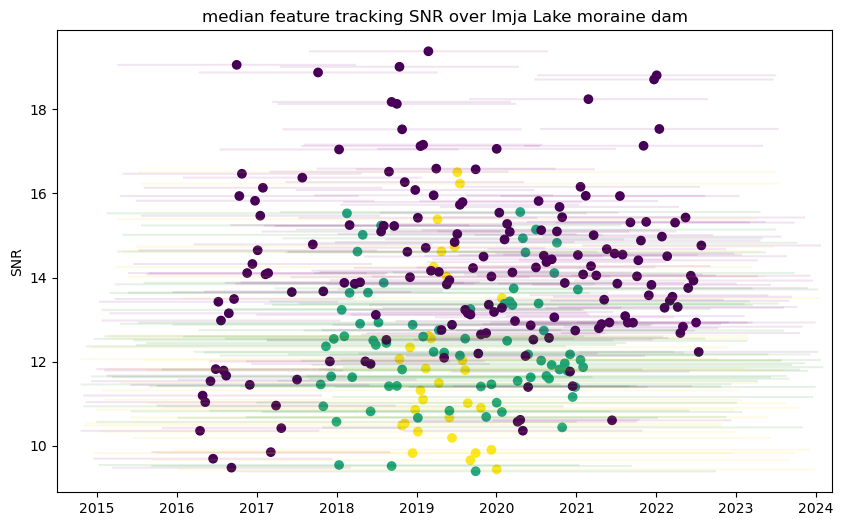

In [223]:

f, ax = plt.subplots(figsize=(10, 6))
ax.scatter(middle_dates, imja_offset_ds.snr_ncorr_clipped.median(dim=['x','y']), c=imja_offset_ds.t_baseline)
for snr_lc in snr_lc_all: 
    ax.add_collection(snr_lc)
    snr_lc.set_snap(False) 
ax.set_xlim(2014.5, 2024.2)
ax.set_xticks([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])
ax.set_ylabel('SNR')
ax.set_title('median feature tracking SNR over Imja Lake moraine dam')
f.savefig('imja_dam_snr.png', dpi=300)

In [193]:
# convert middle dates to year fract
middle_dates_3yr = []
for middle_date in imja_offset_3yr_ds.middle_date:
    middle_dates_3yr.append(year_fraction(middle_date.dt))

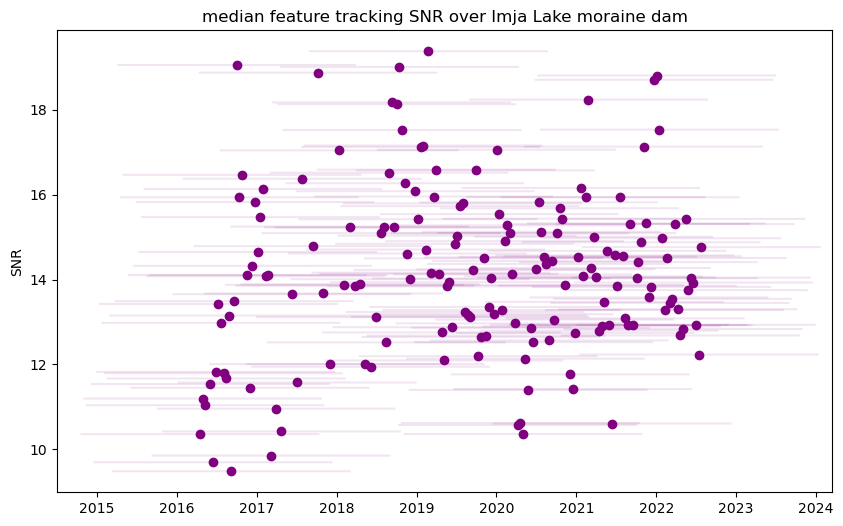

In [224]:
# only three year pairs
colors = ['gold', 'green', 'purple']

snr_lc_all = []
for i, snr_lines in enumerate(snr_lines_all):
    snr_lc = mc.LineCollection(snr_lines, linewidths=1.5, color=(colors[i]), alpha=0.1)
    snr_lc_all.append(snr_lc)

f, ax = plt.subplots(figsize=(10, 6))
ax.scatter(middle_dates_3yr, imja_offset_3yr_ds.snr_ncorr_clipped.median(dim=['x','y']), c='Purple')
ax.add_collection(snr_lc_all[2])
snr_lc_all[2].set_snap(False) 
ax.set_xlim(2014.5, 2024.2)
ax.set_xticks([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])
ax.set_ylabel('SNR')
ax.set_title('median feature tracking SNR over Imja Lake moraine dam')
f.savefig('imja_dam_3yr_snr.png', dpi=300)

In [179]:
# convert middle dates to year fract
middle_dates_6yr = []
for middle_date in imja_offset_6yr_ds.middle_date:
    middle_dates_6yr.append(year_fraction(middle_date.dt))

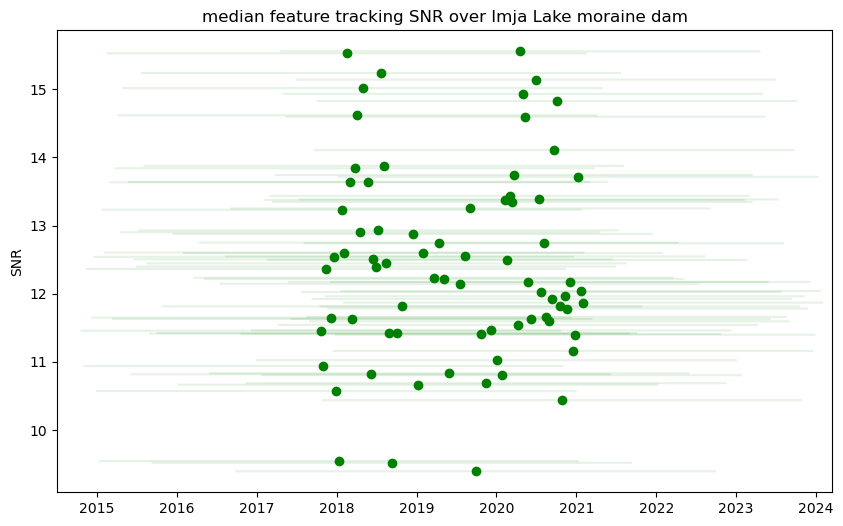

In [225]:
# only six year pairs
colors = ['gold', 'green', 'purple']

snr_lc_all = []
for i, snr_lines in enumerate(snr_lines_all):
    snr_lc = mc.LineCollection(snr_lines, linewidths=1.5, color=(colors[i]), alpha=0.1)
    snr_lc_all.append(snr_lc)

f, ax = plt.subplots(figsize=(10, 6))
ax.scatter(middle_dates_6yr, imja_offset_6yr_ds.snr_ncorr_clipped.median(dim=['x','y']), c='green')
ax.add_collection(snr_lc_all[1])
snr_lc_all[1].set_snap(False) 
ax.set_xlim(2014.5, 2024.2)
ax.set_xticks([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])
ax.set_ylabel('SNR')
ax.set_title('median feature tracking SNR over Imja Lake moraine dam')
f.savefig('imja_dam_6yr_snr.png', dpi=300)

In [186]:
# convert middle dates to year fract
middle_dates_8yr = []
for middle_date in imja_offset_8yr_ds.middle_date:
    middle_dates_8yr.append(year_fraction(middle_date.dt))

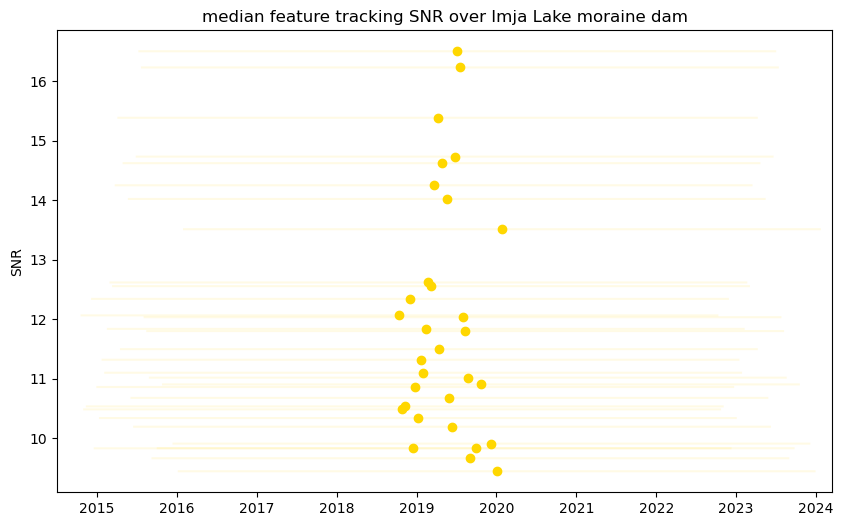

In [226]:
# only eight year pairs
colors = ['gold', 'green', 'purple']

snr_lc_all = []
for i, snr_lines in enumerate(snr_lines_all):
    snr_lc = mc.LineCollection(snr_lines, linewidths=1.5, color=(colors[i]), alpha=0.1)
    snr_lc_all.append(snr_lc)

f, ax = plt.subplots(figsize=(10, 6))
ax.scatter(middle_dates_8yr, imja_offset_8yr_ds.snr_ncorr_clipped.median(dim=['x','y']), c='gold')
ax.add_collection(snr_lc_all[0])
snr_lc_all[0].set_snap(False) 
ax.set_xlim(2014.5, 2024.2)
ax.set_xticks([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])
ax.set_ylabel('SNR')
ax.set_title('median feature tracking SNR over Imja Lake moraine dam')
f.savefig('imja_dam_8yr_snr.png', dpi=300)

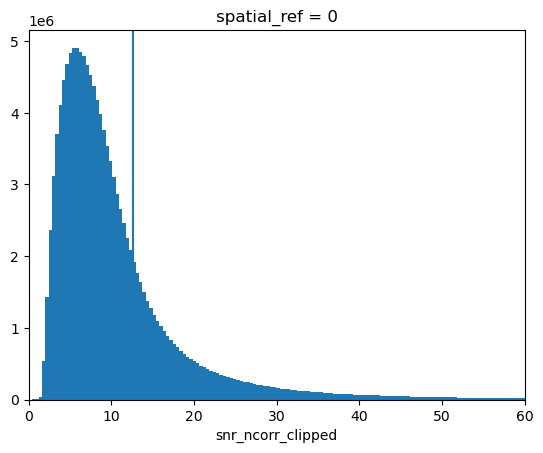

In [247]:
#normalization
f, ax = plt.subplots()
offset_ds.snr_ncorr_clipped.plot.hist(ax=ax, bins=600)
ax.axvline(offset_ds.snr_ncorr_clipped.quantile(0.75), c='k')
ax.set_xlim(0, 60);

In [245]:
offset_ds.snr_ncorr_clipped.quantile(0.75)

<xarray.DataArray 'snr_ncorr_clipped' ()>
array(12.59015751)
Coordinates:
    quantile  float64 0.75

In [ ]:
# # Function to fit a sine wave
# def sine_function(t, amplitude, frequency, phase, offset):
#     return amplitude * np.sin(2 * np.pi * frequency * t + phase) + offset

# # Initial guess for the parameters
# initial_guess = (0.3, 1/3.154e+16, 0.0, 0.0)

# # Perform curve fitting
# params_12, covariance_12 = curve_fit(sine_function, corr_12_ds.middle_date.values.astype(np.int64), corr_12_ds.corr_clipped.mean(dim=['x','y']).values, p0=initial_guess)
# # Perform curve fitting
# params_24, covariance_24 = curve_fit(sine_function, corr_24_ds.middle_date.values.astype(np.int64), corr_24_ds.corr_clipped.mean(dim=['x','y']).values, p0=initial_guess)



# # Extract the fitted parameters
# amplitude_12, frequency_12, phase_12, offset_12 = params_12
# amplitude_24, frequency_24, phase_24, offset_24 = params_24

# # Generate the fitted sine wave
# fitted_sine_wave_12 = sine_function(corr_12_ds.middle_date.values.astype(np.int64), amplitude_12, frequency_12, phase_12, offset_12)
# fitted_sine_wave_24 = sine_function(corr_24_ds.middle_date.values.astype(np.int64), amplitude_24, frequency_24, phase_24, offset_24)

# # Plot the original data and the fitted sine wave
# f, ax = plt.subplots(figsize=(10, 4))
# ax.scatter(corr_12_ds.middle_date, corr_12_ds.corr_clipped.mean(dim=['x','y']).values, label='12 day pairs', s=5)
# ax.scatter(corr_24_ds.middle_date, corr_24_ds.corr_clipped.mean(dim=['x','y']).values, label='24 day pairs', s=5)
# plt.plot(corr_12_ds.middle_date.values, fitted_sine_wave_12, c='darkblue', linewidth=0.8)
# plt.plot(corr_24_ds.middle_date.values, fitted_sine_wave_24, c='darkorange', linewidth=0.8)
# plt.ylabel('coherence')
# plt.legend()
# plt.show()